In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/dataset.zip'

# Destination directory to unzip the files
destination_dir = '/content/unzipped'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

# List the contents of the destination directory
contents = os.listdir(destination_dir)
print("Unzipped contents:", contents)

Mounted at /content/drive
Unzipped contents: ['dataset']


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image

In [3]:
def distribute_images(main_directory, save_directory, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # List all subdirectories in the main directory
    subdirectories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

    # Create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)

    # Create train, val, and test directories in the save directory
    save_train_dir = os.path.join(save_directory, 'train')
    save_val_dir = os.path.join(save_directory, 'val')
    save_test_dir = os.path.join(save_directory, 'test')

    os.makedirs(save_train_dir, exist_ok=True)
    os.makedirs(save_val_dir, exist_ok=True)
    os.makedirs(save_test_dir, exist_ok=True)

    for subdirectory in subdirectories:
        source_dir = os.path.join(main_directory, subdirectory)
        train_subdir = os.path.join(save_train_dir, subdirectory)
        val_subdir = os.path.join(save_val_dir, subdirectory)
        test_subdir = os.path.join(save_test_dir, subdirectory)

        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(val_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # List all files in the source directory
        all_files = os.listdir(source_dir)

        # Calculate the number of files for each split
        num_files = len(all_files)
        num_train = int(num_files * train_ratio)
        num_val = int(num_files * val_ratio)
        num_test = num_files - num_train - num_val

        # Shuffle the files randomly
        random.shuffle(all_files)

        # Copy files to the destination directories based on the ratios
        train_files = all_files[:num_train]
        val_files = all_files[num_train:num_train + num_val]
        test_files = all_files[num_train + num_val:]

        for file in train_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(train_subdir, file))

        for file in val_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(val_subdir, file))

        for file in test_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(test_subdir, file))


main_directory = '/content/unzipped/dataset'
save_to_directory = '/content/unzipped/split_data'
os.makedirs(save_to_directory, exist_ok=True)  # Create the save_to_directory if it doesn't exist
distribute_images(main_directory, save_to_directory)

In [4]:
# Define constants
batch_size = 32
input_size = (224, 224)  # VGG16 input size

# Data directories
train_dir = '/content/unzipped/split_data/train'
val_dir = '/content/unzipped/split_data/val'
val_dir = '/content/unzipped/split_data/test'

# ImageDataGenerator for training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation set
val_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1969 images belonging to 3 classes.
Found 425 images belonging to 3 classes.
Found 425 images belonging to 3 classes.


In [5]:
# Create the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
vgg16model = Sequential()

# Add the base model layers to the Sequential model
vgg16model.add(base_model)
vgg16model.add(GlobalAveragePooling2D())

# Add custom classification layers
vgg16model.add(Dense(512, activation='relu'))
vgg16model.add(Dense(256, activation='relu'))
vgg16model.add(Dense(128, activation='relu'))
vgg16model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the Adam optimizer
vgg16model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
vgg16history = vgg16model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
61/61 [==============================] - 101s 1s/step - loss: 0.8520 - accuracy: 0.6964 - val_loss: 0.7748 - val_accuracy: 0.6947
Epoch 2/10
61/61 [==============================] - 83s 1s/step - loss: 0.6876 - accuracy: 0.8018 - val_loss: 0.6775 - val_accuracy: 0.6827
Epoch 3/10
61/61 [==============================] - 72s 1s/step - loss: 0.5560 - accuracy: 0.8229 - val_loss: 0.6346 - val_accuracy: 0.7067
Epoch 4/10
61/61 [==============================] - 91s 1s/step - loss: 0.4871 - accuracy: 0.8286 - val_loss: 0.6077 - val_accuracy: 0.7163
Epoch 5/10
61/61 [==============================] - 70s 1s/step - loss: 0.4378 - accuracy: 0.8332 - val_loss: 0.5001 - val_accuracy: 0.7885
Epoch 6/10
61/61 [==============================] - 66s 1s/step - loss: 0.4002 - accuracy: 0.8503 - val_loss: 0.5300 - val_accuracy: 0.7668
Epoch 7/10
61/61 [==============================] - 66s 1s/step - loss: 0.3704 - accuracy: 0.8

In [6]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(model, generator, target_names):
    # Get predictions
    predictions = model.predict(generator)
    y_true = generator.classes
    y_pred = np.argmax(predictions, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

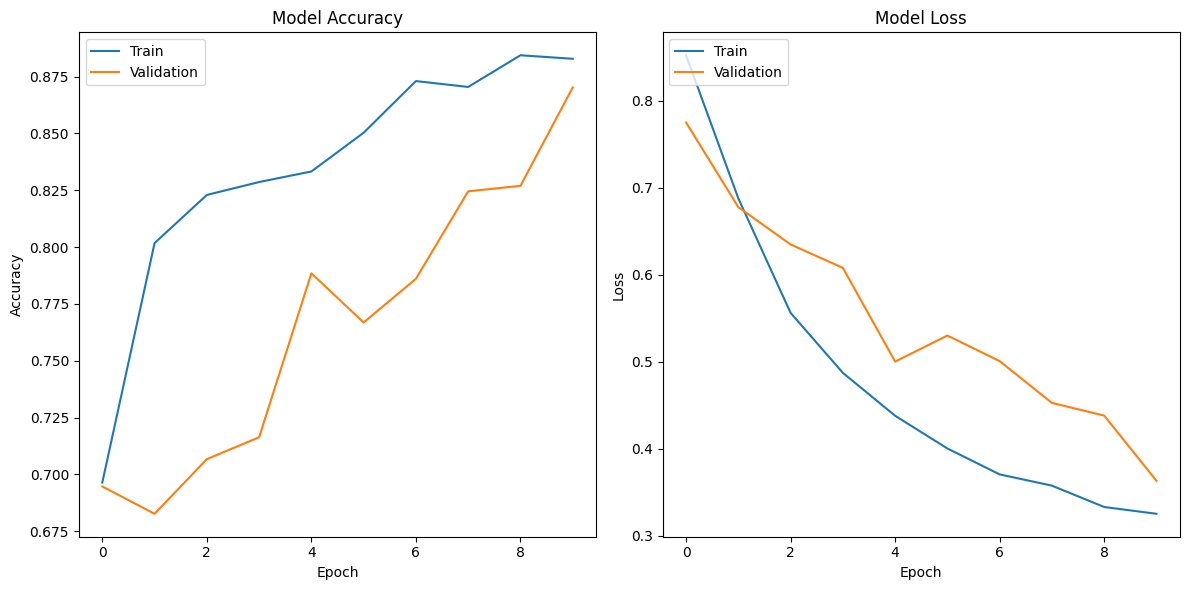

14/14 [==============================] - 10s 749ms/step


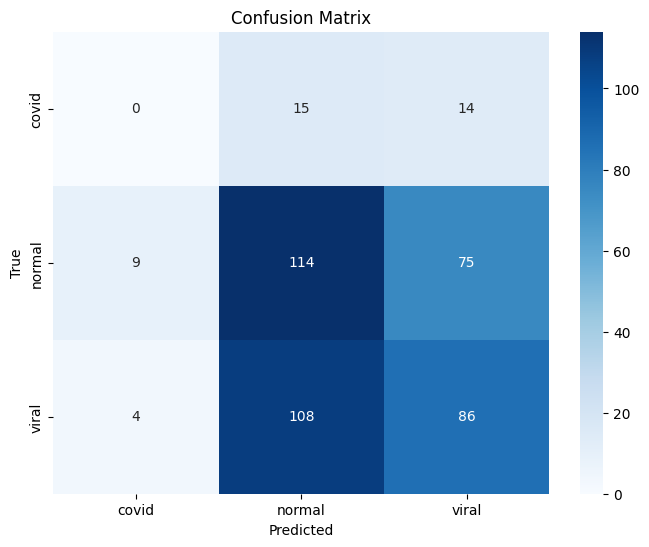

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Plot training history
plot_training_history(vgg16history)

# Plot confusion matrix for the validation set
plot_confusion_matrix(vgg16model, test_generator, target_names=test_generator.class_indices.keys())

# Save the model
vgg16model.save('/content/drive/My Drive/vgg16_model.h5')

14/14 [==============================] - 9s 622ms/step


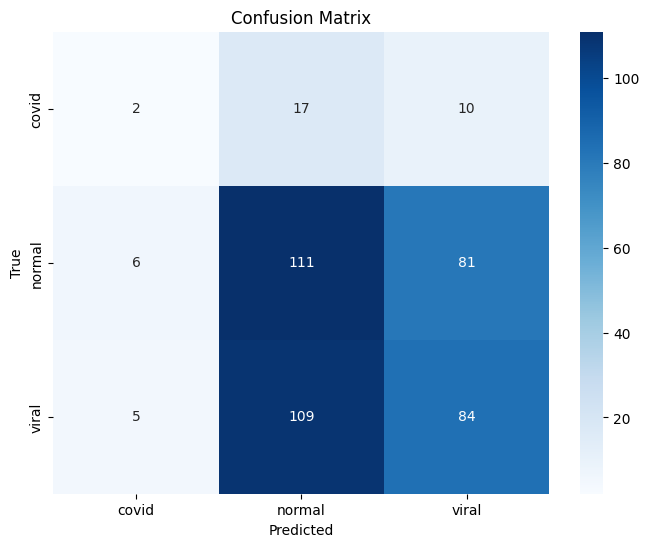

In [21]:
plot_confusion_matrix(vgg16model, val_generator, target_names=val_generator.class_indices.keys())


In [9]:
# Create the base model (VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
vgg19model = Sequential()

# Add the base model layers to the Sequential model
vgg19model.add(base_model)
vgg19model.add(GlobalAveragePooling2D())

# Add custom classification layers
vgg19model.add(Dense(512, activation='relu'))
vgg19model.add(Dense(256, activation='relu'))
vgg19model.add(Dense(128, activation='relu'))
vgg19model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the Adam optimizer
vgg19model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
vgg19history = vgg19model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

Epoch 1/10
61/61 [==============================] - 70s 1s/step - loss: 0.8333 - accuracy: 0.6536 - val_loss: 0.7456 - val_accuracy: 0.7933
Epoch 2/10
61/61 [==============================] - 64s 1s/step - loss: 0.6782 - accuracy: 0.7739 - val_loss: 0.6586 - val_accuracy: 0.6995
Epoch 3/10
61/61 [==============================] - 66s 1s/step - loss: 0.5628 - accuracy: 0.8049 - val_loss: 0.5590 - val_accuracy: 0.8005
Epoch 4/10
61/61 [==============================] - 71s 1s/step - loss: 0.5063 - accuracy: 0.8064 - val_loss: 0.5845 - val_accuracy: 0.7524
Epoch 5/10
61/61 [==============================] - 65s 1s/step - loss: 0.4803 - accuracy: 0.8136 - val_loss: 0.4986 - val_accuracy: 0.8029
Epoch 6/10
61/61 [==============================] - 64s 1s/step - loss: 0.4566 - accuracy: 0.8250 - val_loss: 0.5315 - val_accuracy: 0.7764
Epoch 7/10
61/61 [==============================] - 68s 1s/step - loss: 0.4407 - accuracy: 0.8369 - val_loss: 0.5192 - val_accuracy: 0.8005
Epoch 8/10
61/61 [==

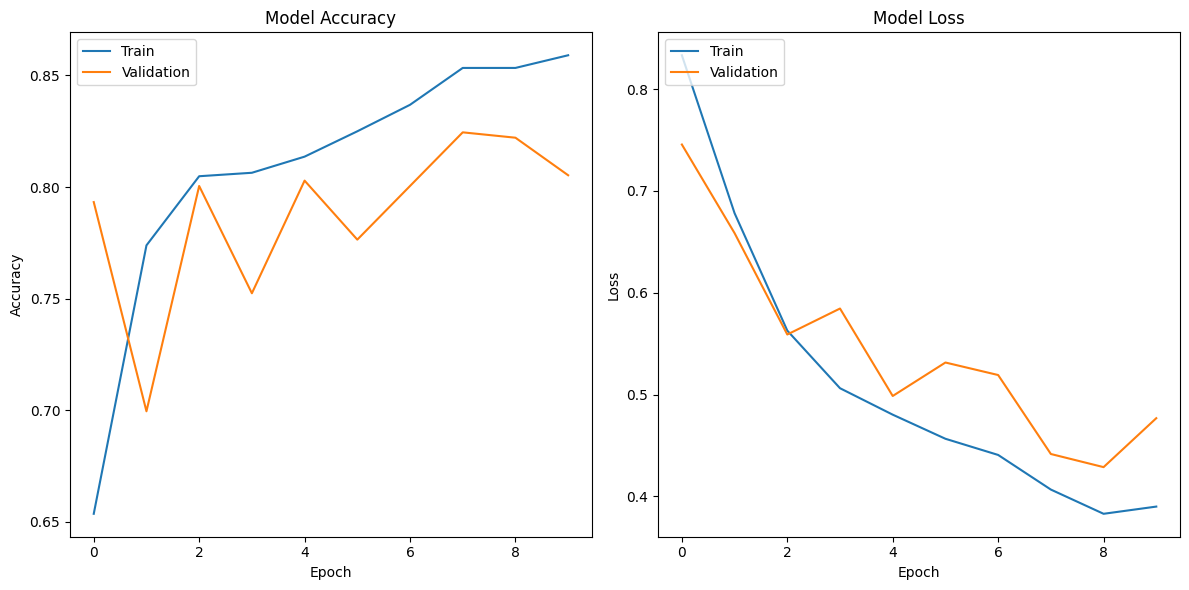

14/14 [==============================] - 8s 545ms/step


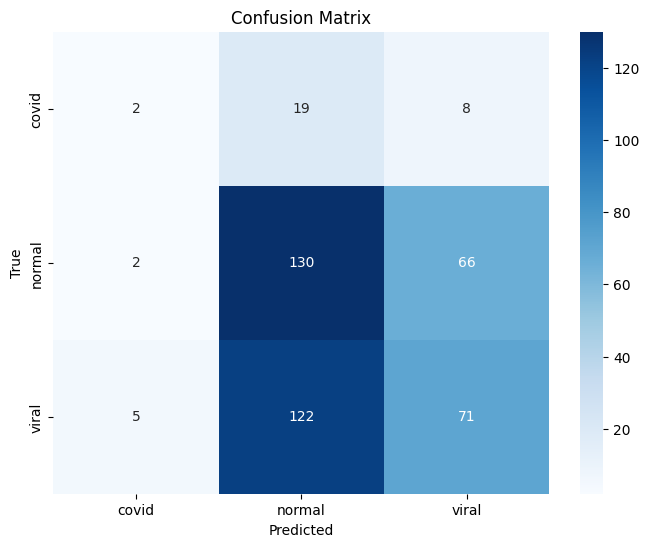

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Plot training history for VGG19
plot_training_history(vgg19history)

# Plot confusion matrix for the validation set using VGG19
plot_confusion_matrix(vgg19model, test_generator, target_names=test_generator.class_indices.keys())

# Save the VGG19 model
vgg19model.save('/content/drive/My Drive/vgg19_model.h5')

14/14 [==============================] - 8s 581ms/step


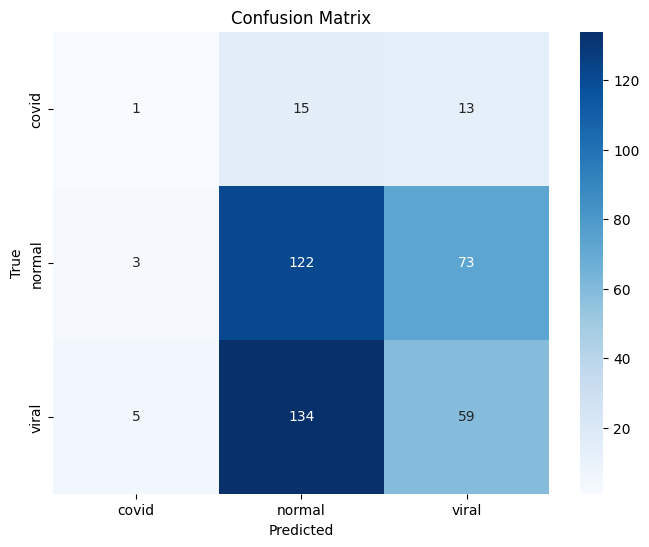

In [20]:
plot_confusion_matrix(vgg19model, val_generator, target_names=val_generator.class_indices.keys())

In [11]:
# Create the base model (ResNet18)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
resnet101model = Sequential()

# Add the base model layers to the Sequential model
resnet101model.add(base_model)
resnet101model.add(GlobalAveragePooling2D())

# Add custom classification layers
resnet101model.add(Dense(512, activation='relu'))
resnet101model.add(Dense(256, activation='relu'))
resnet101model.add(Dense(128, activation='relu'))
resnet101model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the Adam optimizer
resnet101model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
resnet101history = resnet101model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/10
61/61 [==============================] - 84s 1s/step - loss: 0.8822 - accuracy: 0.5421 - val_loss: 0.8615 - val_accuracy: 0.5841
Epoch 2/10
61/61 [==============================] - 67s 1s/step - loss: 0.8387 - accuracy: 0.6164 - val_loss: 0.8308 - val_accuracy: 0.6779
Epoch 3/10
61/61 [==============================] - 69s 1s/step - loss: 0.8080 - accuracy: 0.6445 - val_loss: 0.7908 - val_accuracy: 0.7091
Epoch 4/10
61/61 [==============================] - 69s 1s/step - loss: 0.7664 - accuracy: 0.6892 - val_loss: 0.7607 - val_accuracy: 0.6562
Epoch 5/10
61/61 [==============================] - 69s 1s/step - loss: 0.7285 - accuracy: 0.7052 - val_loss: 0.7181 - val_accuracy: 0.7380
Epoch 6/10
61/61 [==============================] - 66s 1s/step - loss: 0.7100 - accuracy: 0.7052 - val_loss: 0.6929 - val_accuracy: 0.7356
Epoch 7/10
61/61 [==============================] - 71s 1s/step - loss: 0.6901 - accuracy: 0.

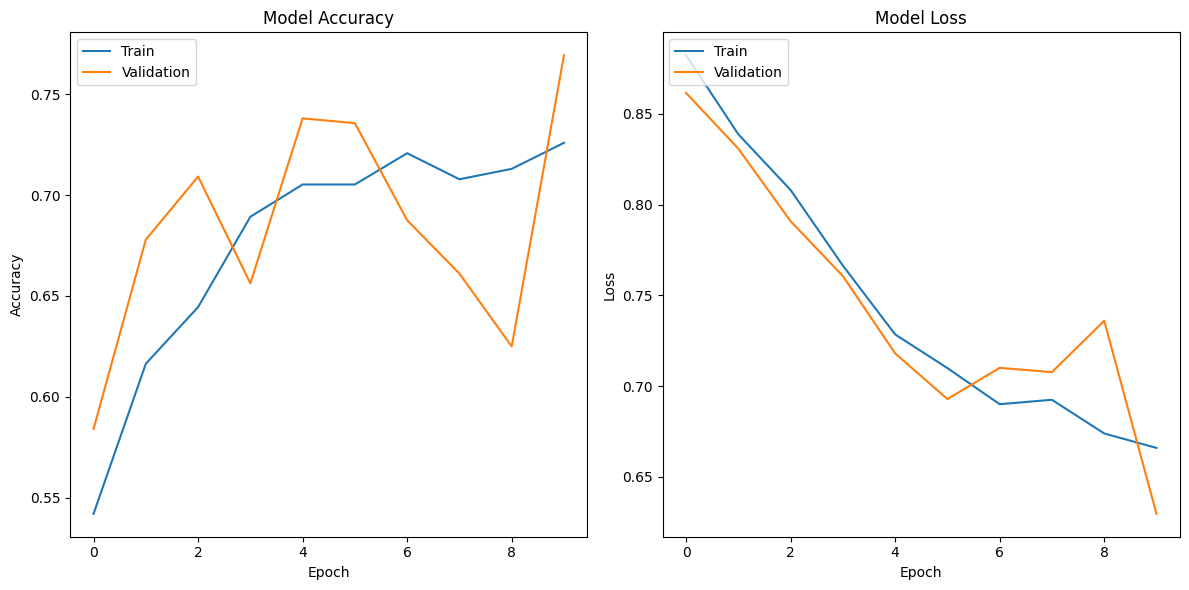

14/14 [==============================] - 12s 711ms/step


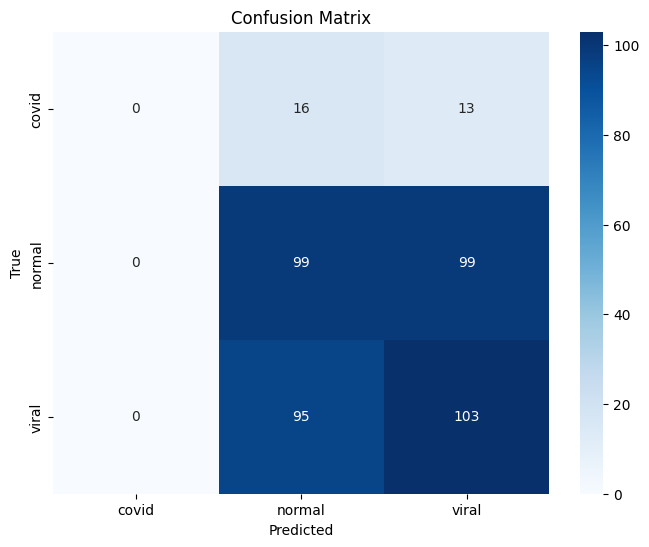

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Plot training history for resnet18
plot_training_history(resnet101history)

# Plot confusion matrix for the validation set using resnet18
plot_confusion_matrix(resnet101model, test_generator, target_names=test_generator.class_indices.keys())

# Save the VGG19 model
resnet101model.save('/content/drive/My Drive/resnet101_model.h5')

14/14 [==============================] - 9s 658ms/step


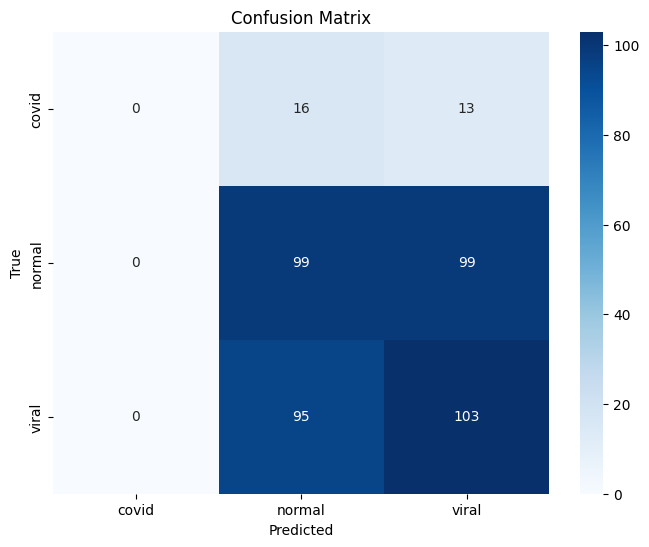

In [19]:
plot_confusion_matrix(resnet101model, val_generator, target_names=val_generator.class_indices.keys())

In [13]:
# Create the base model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
resnet50model = Sequential()

# Add the base model layers to the Sequential model
resnet50model.add(base_model)
resnet50model.add(GlobalAveragePooling2D())

# Add custom classification layers
resnet50model.add(Dense(512, activation='relu'))
resnet50model.add(Dense(256, activation='relu'))
resnet50model.add(Dense(128, activation='relu'))
resnet50model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the Adam optimizer
resnet50model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
resnet50history = resnet50model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
61/61 [==============================] - 78s 1s/step - loss: 0.8978 - accuracy: 0.4817 - val_loss: 0.8802 - val_accuracy: 0.4688
Epoch 2/10
61/61 [==============================] - 70s 1s/step - loss: 0.8744 - accuracy: 0.5529 - val_loss: 0.8612 - val_accuracy: 0.6298
Epoch 3/10
61/61 [==============================] - 70s 1s/step - loss: 0.8548 - accuracy: 0.5932 - val_loss: 0.8356 - val_accuracy: 0.6731
Epoch 4/10
61/61 [==============================] - 67s 1s/step - loss: 0.8354 - accuracy: 0.6257 - val_loss: 0.8360 - val_accuracy: 0.5337
Epoch 5/10
61/61 [==============================] - 68s 1s/step - loss: 0.8345 - accuracy: 0.5999 - val_loss: 0.8317 - val_accuracy: 0.5529
Epoch 6/10
61/61 [==============================] - 70s 1s/step - loss: 0.8055 - accuracy: 0.6433 - val_loss: 0.7686 - val_accuracy: 0.7452
Epoch 7/10
61/61 [==============================] - 67s 1s/step - loss: 0.7864 - accuracy: 0.67

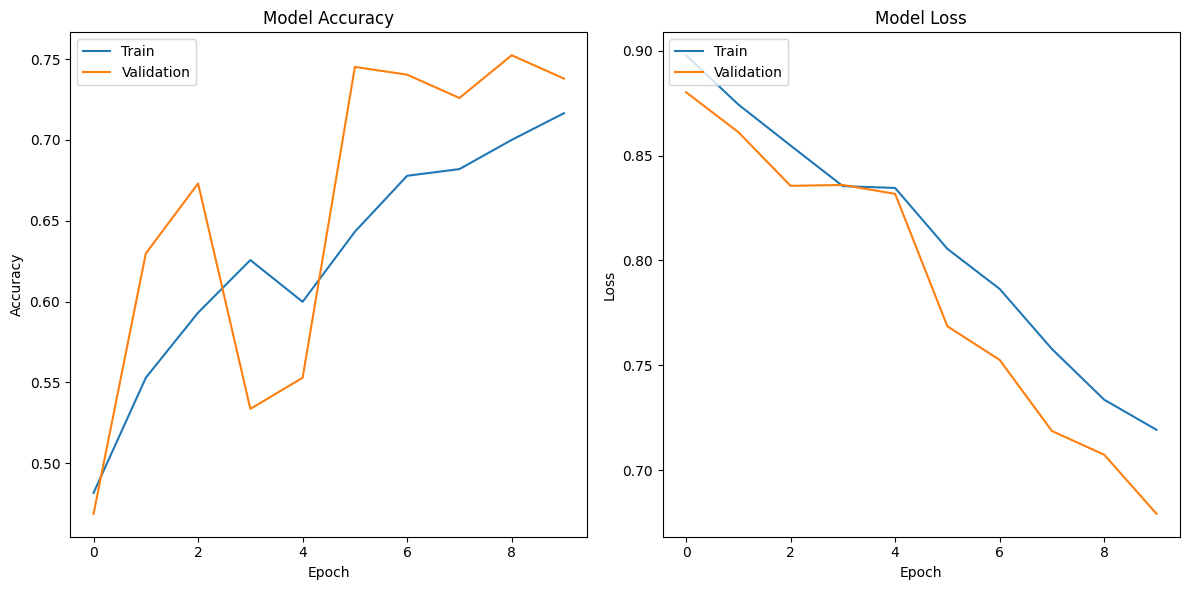

14/14 [==============================] - 9s 615ms/step


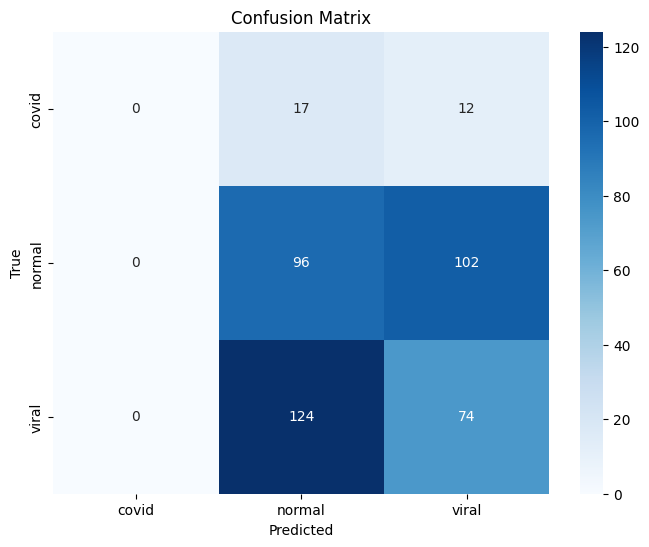

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Plot training history for resnet50
plot_training_history(resnet50history)

# Plot confusion matrix for the validation set using resnet18
plot_confusion_matrix(resnet50model, test_generator, target_names=test_generator.class_indices.keys())

# Save the VGG19 model
resnet50model.save('/content/drive/My Drive/resnet50_model.h5')

14/14 [==============================] - 11s 755ms/step


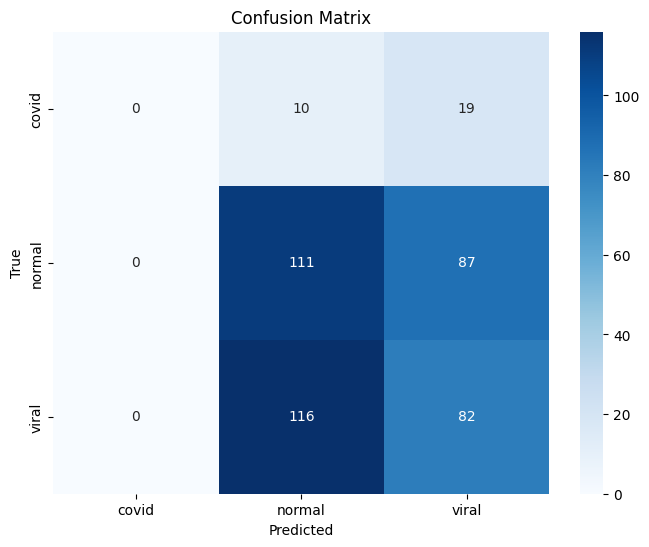

In [18]:
plot_confusion_matrix(resnet50model, val_generator, target_names=val_generator.class_indices.keys())

In [15]:
# Create the base model (InceptionV3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
inception_model = Sequential()

# Add the base model layers to the Sequential model
inception_model.add(base_model)
inception_model.add(GlobalAveragePooling2D())

# Add custom classification layers
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dense(256, activation='relu'))
inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the Adam optimizer
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
61/61 [==============================] - 82s 1s/step - loss: 0.5472 - accuracy: 0.7651 - val_loss: 0.4252 - val_accuracy: 0.8317
Epoch 2/10
61/61 [==============================] - 70s 1s/step - loss: 0.3803 - accuracy: 0.8544 - val_loss: 0.4262 - val_accuracy: 0.8101
Epoch 3/10
61/61 [==============================] - 65s 1s/step - loss: 0.3647 - accuracy: 0.8493 - val_loss: 0.3777 - val_accuracy: 0.8462
Epoch 4/10
61/61 [==============================] - 71s 1s/step - loss: 0.2928 - accuracy: 0.8844 - val_loss: 0.4127 - val_accuracy: 0.8029
Epoch 5/10
61/61 [==============================] - 66s 1s/step - loss: 0.2904 - accuracy: 0.8957 - val_loss: 0.5070 - val_accuracy: 0.7692
Epoch 6/10
61/61 [==============================] - 67s 1s/step - loss: 0.2921 - accuracy: 0.8947 - val_loss: 0.3492 - val_accuracy: 0.8630
Epoch 7/10
61/61 [==============================] - 71s 1s/step - loss: 0.2691 - accuracy: 0.90

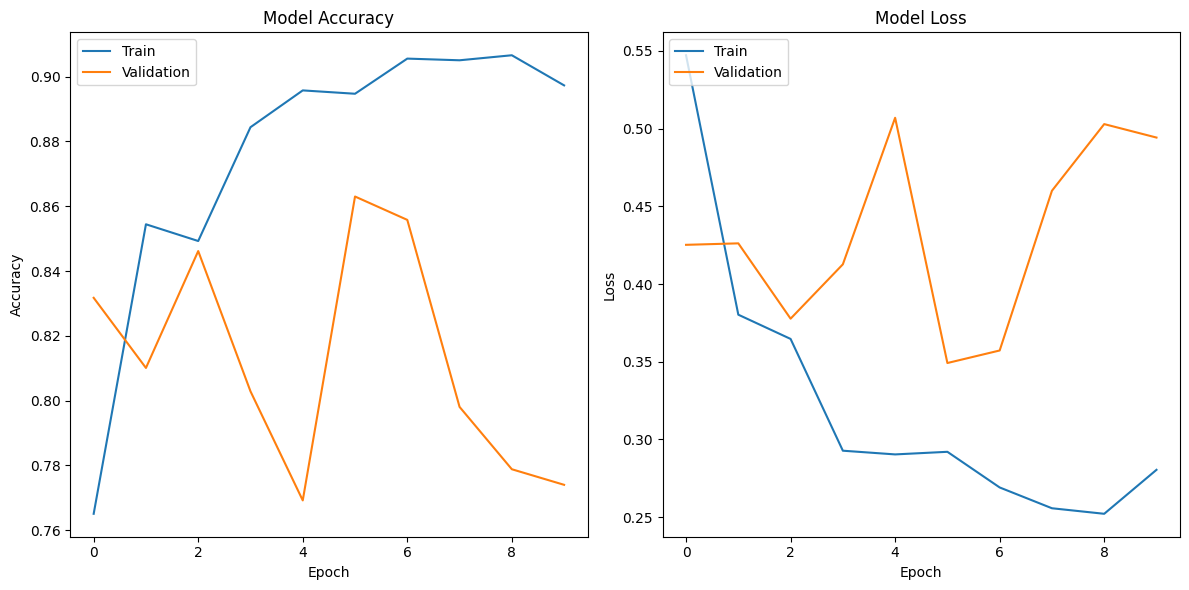

14/14 [==============================] - 12s 706ms/step


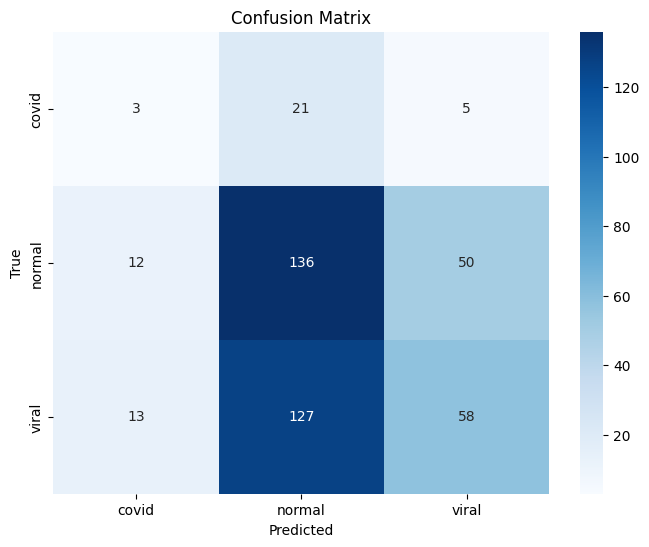

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Plot training history for resnet18
plot_training_history(inception_history)

# Plot confusion matrix for the validation set using resnet18
plot_confusion_matrix(inception_model, test_generator, target_names=test_generator.class_indices.keys())

# Save the VGG19 model
inception_model.save('/content/drive/My Drive/inception_model.h5')

14/14 [==============================] - 9s 594ms/step


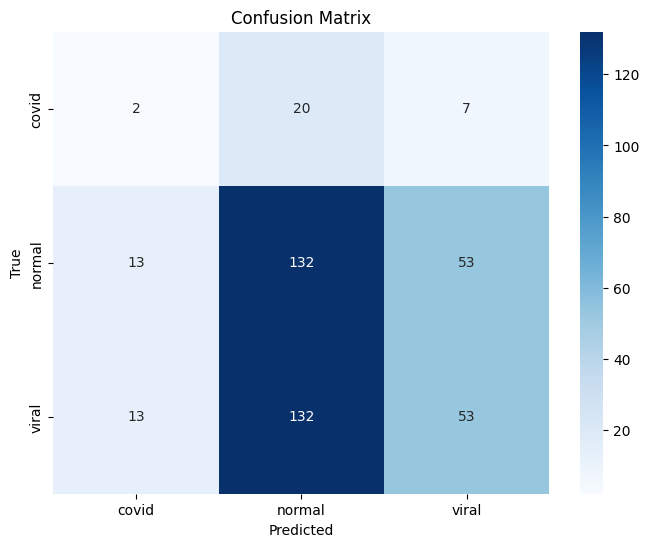

In [17]:
plot_confusion_matrix(inception_model, val_generator, target_names=val_generator.class_indices.keys())
